# Toggle-Frame Example Problem: Single Drive

This notebook illustrates the effectiveness of the toggling-frame robustness objective for both multiplicative and additive errors for a single pauli X drive and Hadamard as the unitary goal. It's strucuted as follows:
* Imports
* Problem Setup 
* Problem Solve
* Plot fidelity swept over additive & multiplicative error 
* Save trjaectories to file

## Imports

In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();
Pkg.develop(path="../../QuantumCollocation.jl")
using PiccoloQuantumObjects
using QuantumCollocation
using ForwardDiff
using LinearAlgebra
using Plots
using SparseArrays
using Statistics
using CairoMakie
using NamedTrajectories
using TrajectoryIndexingUtils
using Random

  Activating project at `~/Documents/GitHub/robust_control_sam/src`
┌ Warning: The project dependencies or compat requirements have changed since the manifest was last resolved.
│ It is recommended to `Pkg.resolve()` or consider `Pkg.update()` if necessary.
└ @ Pkg.API /Users/andrewkamen/.julia/juliaup/julia-1.11.5+0.aarch64.apple.darwin14/share/julia/stdlib/v1.11/Pkg/src/API.jl:1206
   Installed Bijections ───────────── v0.2.2
   Installed JpegTurbo_jll ────────── v3.1.3+0
   Installed SciMLPublic ──────────── v1.0.0
   Installed SciMLJacobianOperators ─ v0.1.11
   Installed AxisArrays ───────────── v0.4.8
   Installed FindFirstFunctions ───── v1.4.2
   Installed StaticArrays ─────────── v1.9.15
   Installed DataFrames ───────────── v1.7.1
   Installed Combinatorics ────────── v1.0.2
   Installed SymbolicLimits ───────── v0.2.3
   Installed EnzymeCore ───────────── v0.8.13
   Installed Symbolics ────────────── v6.54.0
   Installed Ghostscript_jll ──────── v9.55.1+0
   Installed ArrayI

## Problem Setup

In [178]:
# Problem parameters
T = 40
Δt = 0.1
U_goal = exp(- 1.0im * π * PAULIS.X / 4)
Δ = 0.0 # detuning
H_drift = Δ * PAULIS.Z
H_drive = [PAULIS.X, PAULIS.Y, PAULIS.Z]
a_bound = 2.0
dda_bound = 5.0
piccolo_opts = PiccoloOptions(verbose=false)
pretty_print(X::AbstractMatrix) = Base.show(stdout, "text/plain", X);
sys = QuantumSystem(H_drift, H_drive)

QuantumSystem: levels = 2, n_drives = 3

In [179]:
H_drive_var = a -> a[1] * PAULIS.X + a[2] * PAULIS.Y + a[3] * PAULIS.Z
H_vars_input = a -> PAULIS.Z
H_vars_array = Function[H_vars_input]
varsys = VariationalQuantumSystem(
    H_drive,
    [PAULIS.X + PAULIS.Y + PAULIS.Z]
)

var_prob = UnitaryVariationalProblem(
    varsys, U_goal, T, Δt;
    piccolo_options=piccolo_opts,
    robust_times=[[T]]
)

solve!(var_prob, max_iter=50, print_level=5)

In [180]:
# additive error Hamiltonian
Hₑ_add = a -> PAULIS.X

# multiplicative error Hamiltonian
# X_drive = sys.H.H_drives[1]
# Hₑ_mult = a -> a[1] * X_drive

# no robustness
default = UnitarySmoothPulseProblem(sys, U_goal, T, Δt)
solve!(default, max_iter=50, print_level=5)

# additive robustness
# add_prob = UnitarySmoothPulseProblem(
#             sys, U_goal, T, Δt;
#             piccolo_options=piccolo_opts,
#             activate_rob_loss=true,
#             H_err=Hₑ_add,
#             Q_t=1.0
#         )
# solve!(add_prob, max_iter=200, print_level=5)

# multiplicative robustness
# mult_prob = UnitarySmoothPulseProblem(
#     sys, U_goal, T, Δt;
#     piccolo_options=piccolo_opts,
#     activate_rob_loss=true,
#     H_err=Hₑ_mult,
#     Q_t=1.0
# )
# solve!(mult_prob, max_iter=200, print_level=5)

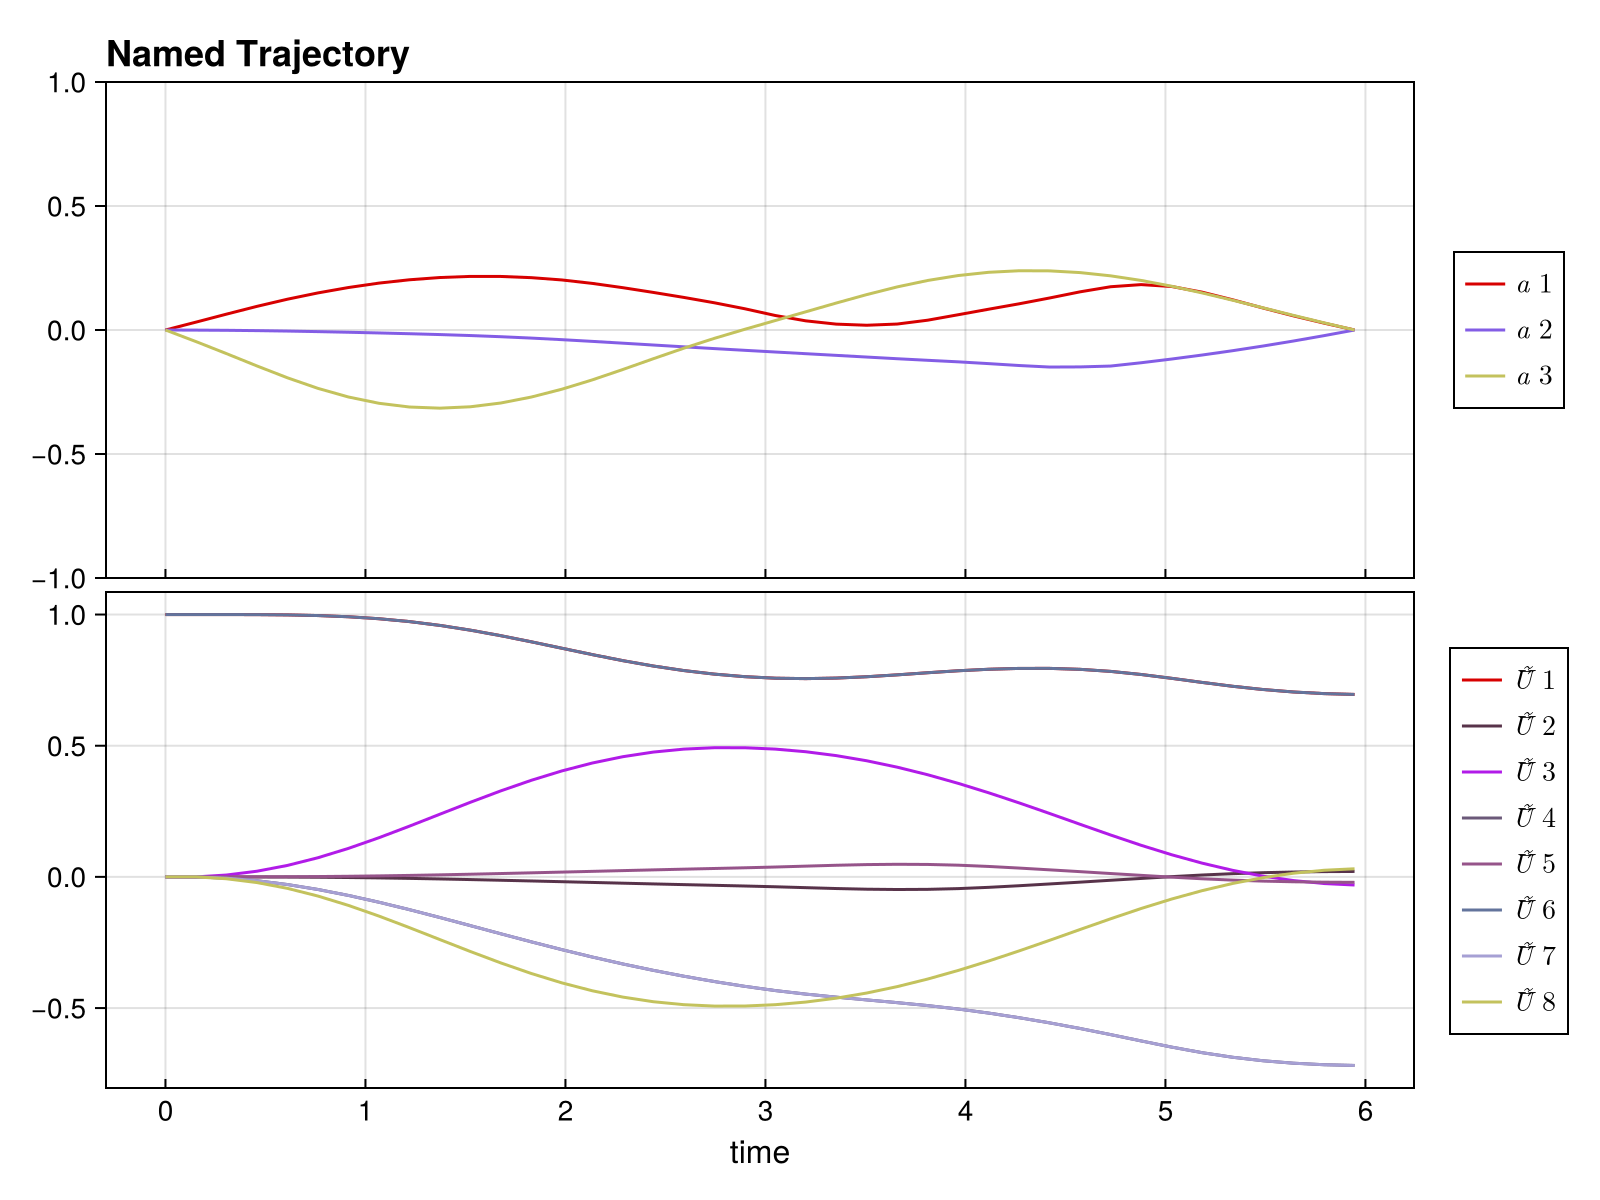

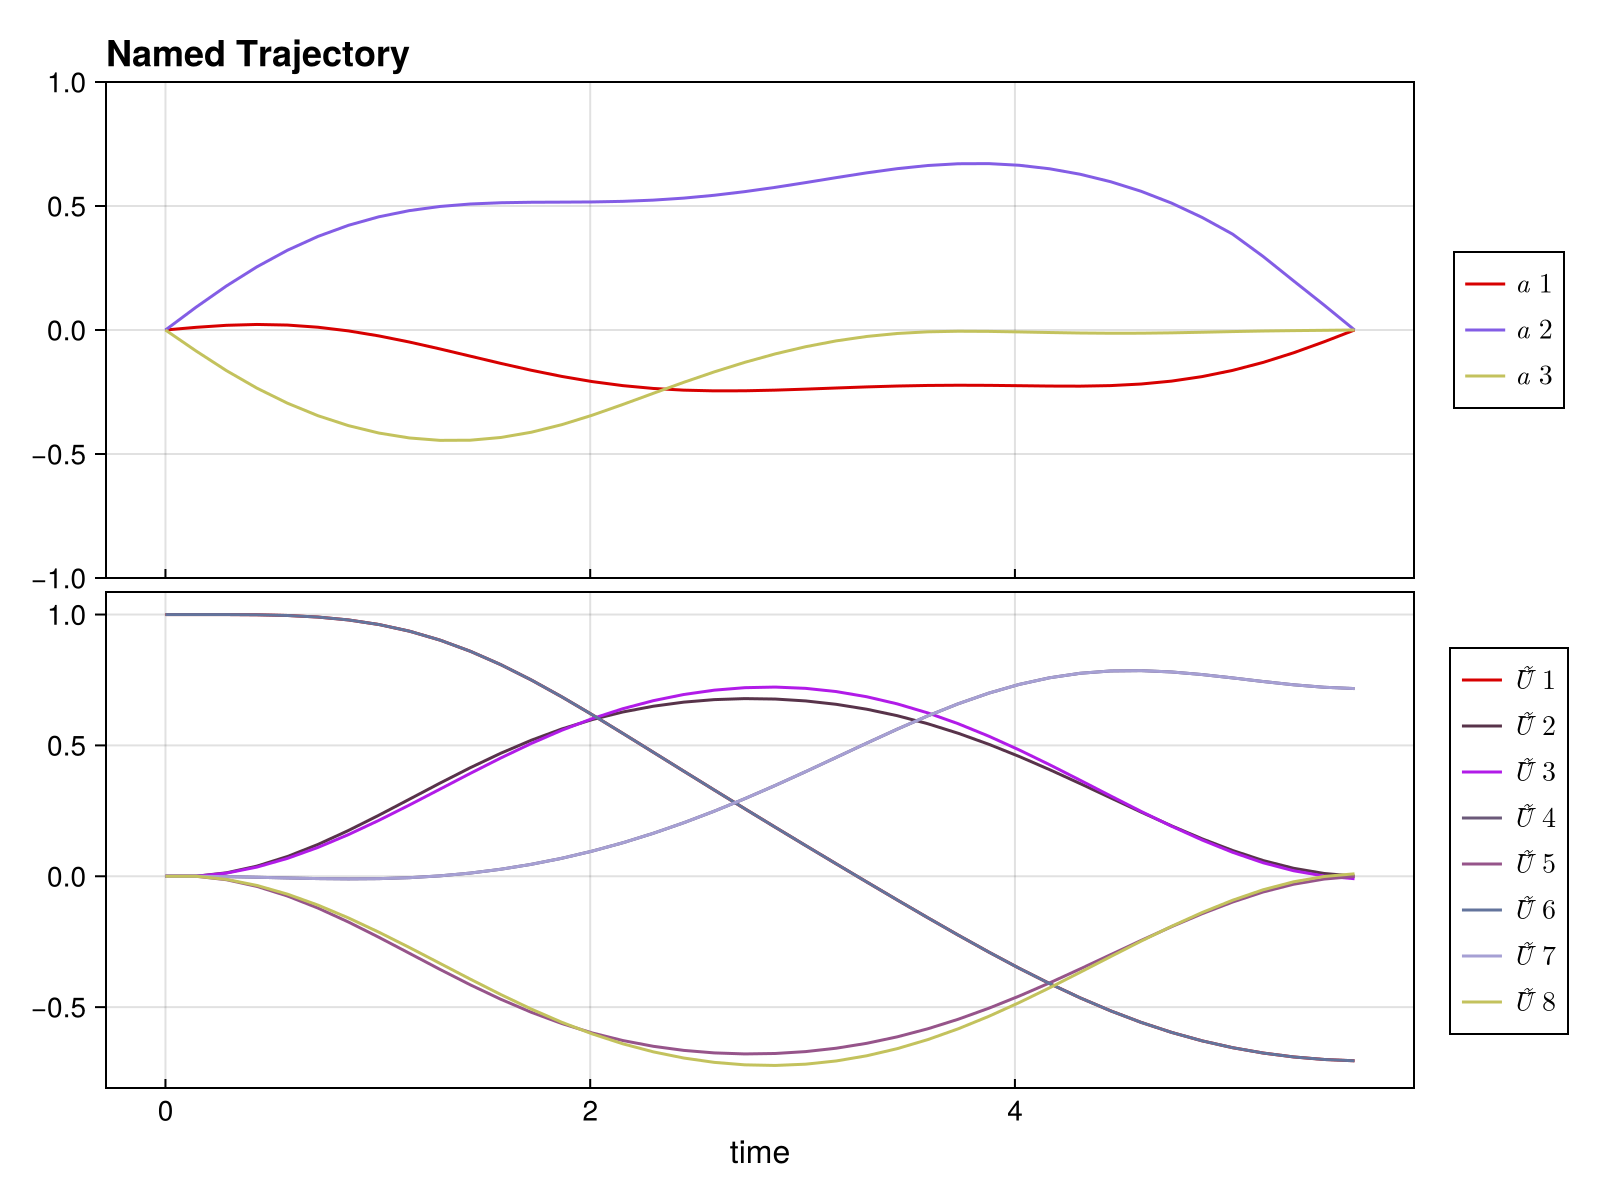

CairoMakie.Screen{IMAGE}


In [181]:
p1 = CairoMakie.plot(default.trajectory, [:a, :Ũ⃗])
#p2 = CairoMakie.plot(add_prob.trajectory, [:a, :Ũ⃗])
p2 = CairoMakie.plot(var_prob.trajectory, [:a, :Ũ⃗])

display(p1)
display(p2)
#display(p3)

#### Plotting

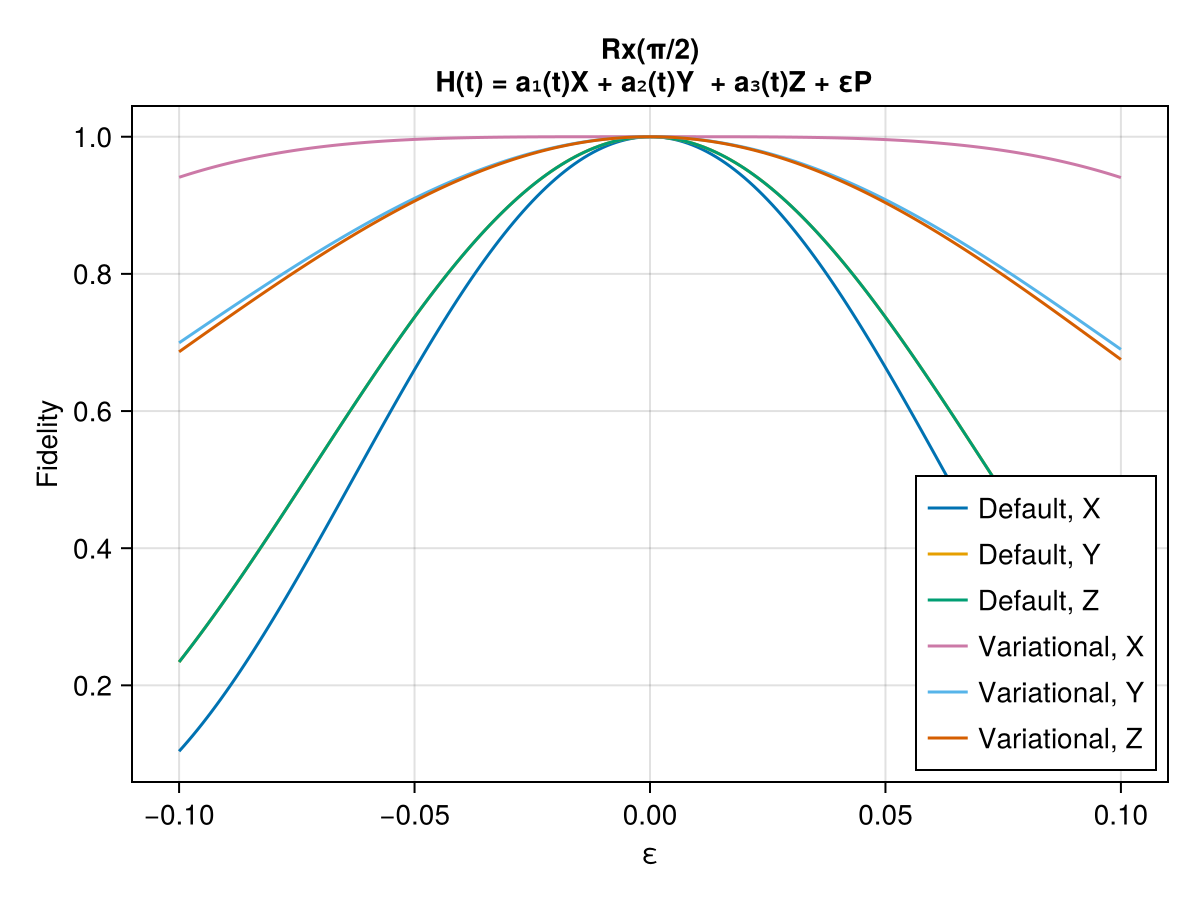

In [155]:
H_drive_add = H_drive

f = Figure()
ax1 = Axis(f[1, 1],
    title = "Rx(π/2)\n H(t) = a₁(t)X + a₂(t)Y  + a₃(t)Z + εP",
    xlabel = "ε",
    ylabel = "Fidelity"
)
#ax2 = Axis(f[2, 1], title="multiplicative")

colors = Makie.wong_colors()

εs = -.1:0.001:.1

# default case (smooth, non-variational, w/o toggling obj)
ys = [unitary_rollout_fidelity(default.trajectory, QuantumSystem(ε * PAULIS.X + H_drift, [PAULIS.X, PAULIS.Y, PAULIS.Z])) for ε in εs]
lines!(ax1, εs, ys, label="Default, X", color=colors[1], linestyle=:solid)

ys = [unitary_rollout_fidelity(default.trajectory, QuantumSystem(ε * PAULIS.Y + H_drift, [PAULIS.X, PAULIS.Y, PAULIS.Z])) for ε in εs]
lines!(ax1, εs, ys, label="Default, Y", color=colors[2], linestyle=:solid)

ys = [unitary_rollout_fidelity(default.trajectory, QuantumSystem(ε * PAULIS.Z + H_drift, [PAULIS.X, PAULIS.Y, PAULIS.Z])) for ε in εs]
lines!(ax1, εs, ys, label="Default, Z", color=colors[3], linestyle=:solid)

# ys = [unitary_rollout_fidelity(default.trajectory, QuantumSystem(H_drift, [(1 + ε) * PAULIS.X])) for ε in εs]
# lines!(ax2, εs, ys, label="default", color=colors[1], linestyle=:solid)

# toggling obj

# (add)
# ys = [unitary_rollout_fidelity(add_prob.trajectory, QuantumSystem(ε * PAULIS.Z + H_drift, [PAULIS.X])) for ε in εs]
# lines!(ax1, εs, ys, label="Robust", color=colors[2], linestyle=:solid)

ys = [unitary_rollout_fidelity(var_prob.trajectory, QuantumSystem(ε * PAULIS.X + H_drift, [PAULIS.X, PAULIS.Y, PAULIS.Z])) for ε in εs]
lines!(ax1, εs, ys, label="Variational, X", color=colors[4], linestyle=:solid)

ys = [unitary_rollout_fidelity(var_prob.trajectory, QuantumSystem(ε * PAULIS.Y + H_drift, [PAULIS.X, PAULIS.Y, PAULIS.Z])) for ε in εs]
lines!(ax1, εs, ys, label="Variational, Y", color=colors[5], linestyle=:solid)

ys = [unitary_rollout_fidelity(var_prob.trajectory, QuantumSystem(ε * PAULIS.Z + H_drift, [PAULIS.X, PAULIS.Y, PAULIS.Z])) for ε in εs]
lines!(ax1, εs, ys, label="Variational, Z", color=colors[6], linestyle=:solid)

# ys = [unitary_rollout_fidelity(add_prob.trajectory, QuantumSystem(H_drift, [(1 + ε) * PAULIS.X])) for ε in εs]
# lines!(ax2, εs, ys, label="add toggle", color=colors[2], linestyle=:solid)

# (mult)
# ys = [unitary_rollout_fidelity(mult_prob.trajectory, QuantumSystem(ε * PAULIS.X + H_drift, [PAULIS.X])) for ε in εs]
# lines!(ax1, εs, ys, label="mult toggle", color=colors[6], linestyle=:solid)

# ys = [unitary_rollout_fidelity(mult_prob.trajectory, QuantumSystem(H_drift, [(1 + ε) * PAULIS.X])) for ε in εs]
# lines!(ax2, εs, ys, label="mult toggle", color=colors[6], linestyle=:solid)

# # (both)
# ys = [unitary_rollout_fidelity(both_prob.trajectory, QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])) for ε in εs]
# lines!(ax1, εs, ys, label="both toggle", color=colors[4], linestyle=:solid)

# ys = [unitary_rollout_fidelity(both_prob.trajectory, QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])) for ε in εs]
# lines!(ax2, εs, ys, label="both toggle", color=colors[4], linestyle=:solid)

axislegend(ax1; position = :rb, tellwidth = false, tellheight = false)
#Legend(f[2,2], ax2, position=:lb)

f


In [189]:
add_traj = var_prob.trajectory
default_traj = default.trajectory

function SpaceCurve(traj::NamedTrajectory, U_goal::AbstractMatrix{<:Number}, H_err::AbstractMatrix{<:Number})
    T = traj.T
    first_order_terms = Vector{Matrix{ComplexF64}}(undef, T)
    first_order_integral = zeros(ComplexF64, size(U_goal))

    for i in 1:T
        U = iso_vec_to_operator(traj.Ũ⃗[:, i])
        first_order_integral += U' * Hₑ * U
        first_order_terms[i] = first_order_integral
    end
    space_curve = [[real(tr(PAULIS.X * first_order_terms[t])),
                    real(tr(PAULIS.Y * first_order_terms[t])),
                    real(tr(PAULIS.Z * first_order_terms[t]))] for t in 1:T] 
    return space_curve
end

SpaceCurve (generic function with 1 method)

In [190]:
add_curve = SpaceCurve(add_traj, U_goal, Hₑ)
default_curve = SpaceCurve(default_traj, U_goal, Hₑ)

40-element Vector{Vector{Float64}}:
 [0.0, 0.0, 2.0]
 [2.4748745636197497e-27, -1.061296593983746e-27, 4.0]
 [0.00015666845406812842, 0.019330988577315307, 5.999906581685877]
 [-4.731157896731541e-5, 0.07764183402798616, 7.999056474773893]
 [-0.002513354439735606, 0.19397508844115097, 9.995669291321239]
 [-0.01119212287089535, 0.38556936576732304, 11.986453854726415]
 [-0.032443372802063795, 0.6668909638631734, 13.966459618123526]
 [-0.0750154581772122, 1.0490865584089248, 15.929148188043571]
 [-0.14956082239711704, 1.539365013287834, 17.866704888596047]
 [-0.267633102493323, 2.1404887924577163, 19.77059468119056]
 ⋮
 [-11.939299075671599, 32.43963169830268, 47.1606417577651]
 [-12.2223167648456, 34.37220540724863, 47.598331235923254]
 [-12.44439654740033, 36.33618448097193, 47.91668226387295]
 [-12.606205739451735, 38.32121841517107, 48.12337433546891]
 [-12.710771387373564, 40.31801309997685, 48.23497401471934]
 [-12.764527975854534, 42.3198766013696, 48.272302798588335]
 [-12.777181

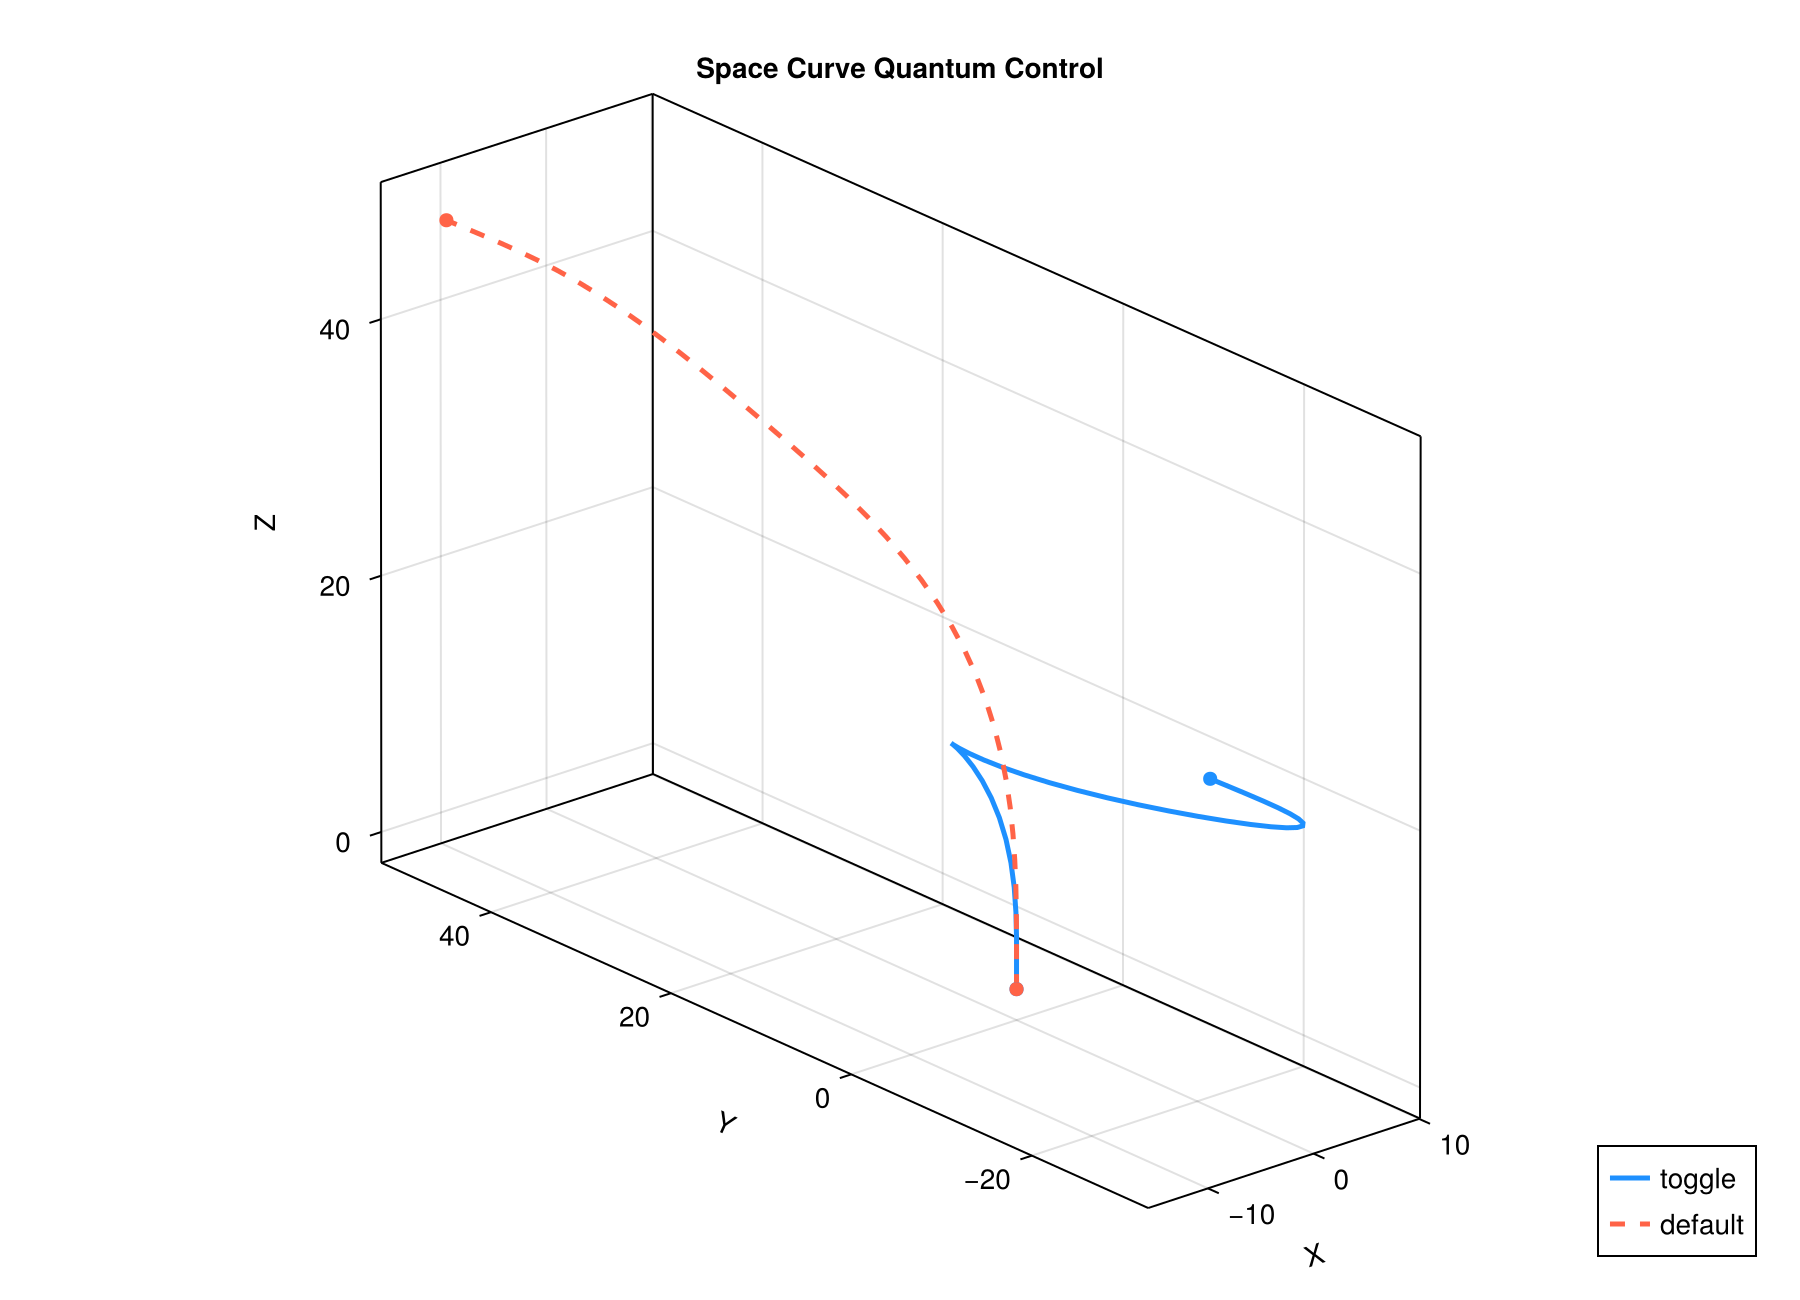

CairoMakie.Screen{IMAGE}


In [191]:
using CairoMakie
const CM = CairoMakie

function to_xyz(curve)
    if curve isa AbstractMatrix
        M = Float64.(real.(curve))
        if size(M, 2) == 3
            x, y, z = M[:, 1], M[:, 2], M[:, 3]
        elseif size(M, 1) == 3
            x, y, z = M[1, :], M[2, :], M[3, :]
        else
            error("Matrix curve must be T×3 or 3×T, got $(size(M))")
        end
    else
        x = Float64.(real.(getindex.(curve, 1)))
        y = Float64.(real.(getindex.(curve, 2)))
        z = Float64.(real.(getindex.(curve, 3)))
    end
    mask = isfinite.(x) .& isfinite.(y) .& isfinite.(z)
    return x[mask], y[mask], z[mask]
end

Hₑ = PAULIS.Z

add_curve     = SpaceCurve(add_traj, U_goal, Hₑ)
default_curve = SpaceCurve(default_traj, U_goal, Hₑ)

x1, y1, z1 = to_xyz(add_curve)
x2, y2, z2 = to_xyz(default_curve)

pushfirst!(x1, 0.0)
pushfirst!(y1, 0.0)
pushfirst!(z1, 0.0)
pushfirst!(x2, 0.0)
pushfirst!(y2, 0.0)
pushfirst!(z2, 0.0)

f  = CM.Figure(size = (900, 650))
ax = CM.Axis3(f[1, 1];
    xlabel = "X", ylabel = "Y", zlabel = "Z",
    title = "Space Curve Quantum Control", aspect = :data
)

CM.lines!(ax, x1, y1, z1; linewidth = 2.5, color = :dodgerblue, label = "toggle")
CM.lines!(ax, x2, y2, z2; linewidth = 2.5, linestyle = :dash, color = :tomato, label = "default")

CM.scatter!(ax, [x1[1]],  [y1[1]],  [z1[1]];  markersize = 10, color = :dodgerblue)
CM.scatter!(ax, [x1[end]],[y1[end]],[z1[end]]; markersize = 10, color = :dodgerblue)
CM.scatter!(ax, [x2[1]],  [y2[1]],  [z2[1]];  markersize = 10, color = :tomato)
CM.scatter!(ax, [x2[end]],[y2[end]],[z2[end]]; markersize = 10, color = :tomato)

CM.axislegend(ax; position = :rb)

display(f)


In [151]:
ket_0 = [0.0,1.0]

rho_0 = ket_0 * ket_0'

expect_val_x = [real(tr(PAULIS.X * iso_vec_to_operator(add_traj.Ũ⃗[:, t]) * rho_0 * iso_vec_to_operator(add_traj.Ũ⃗[:, t])')) for t in 1:add_traj.T]
expect_val_y = [real(tr(PAULIS.Y * iso_vec_to_operator(add_traj.Ũ⃗[:, t]) * rho_0 * iso_vec_to_operator(add_traj.Ũ⃗[:, t])')) for t in 1:add_traj.T]
expect_val_z = [real(tr(PAULIS.Z * iso_vec_to_operator(add_traj.Ũ⃗[:, t]) * rho_0 * iso_vec_to_operator(add_traj.Ũ⃗[:, t])')) for t in 1:add_traj.T]
expect_val_x_1 = [real(tr(PAULIS.X * iso_vec_to_operator(default_traj.Ũ⃗[:, t]) * rho_0 * iso_vec_to_operator(default_traj.Ũ⃗[:, t])')) for t in 1:default_traj.T]
expect_val_y_1 = [real(tr(PAULIS.Y * iso_vec_to_operator(default_traj.Ũ⃗[:, t]) * rho_0 * iso_vec_to_operator(default_traj.Ũ⃗[:, t])')) for t in 1:default_traj.T]
expect_val_z_1 = [real(tr(PAULIS.Z * iso_vec_to_operator(default_traj.Ũ⃗[:, t]) * rho_0 * iso_vec_to_operator(default_traj.Ũ⃗[:, t])')) for t in 1:default_traj.T]


100-element Vector{Float64}:
 -1.0
 -1.0
 -0.9999995633437901
 -0.9999960811822041
 -0.9999844054126674
 -0.9999569761911025
 -0.9999040033599411
 -0.9998136895961205
 -0.9996724851216314
 -0.999465363620791
  ⋮
 -0.05299709920627582
 -0.0412825734996749
 -0.03101386589634958
 -0.022221545439218338
 -0.014920227364270788
 -0.0091100348261135
 -0.004779395176771117
 -0.0019094607166361133
 -0.000480480169323394

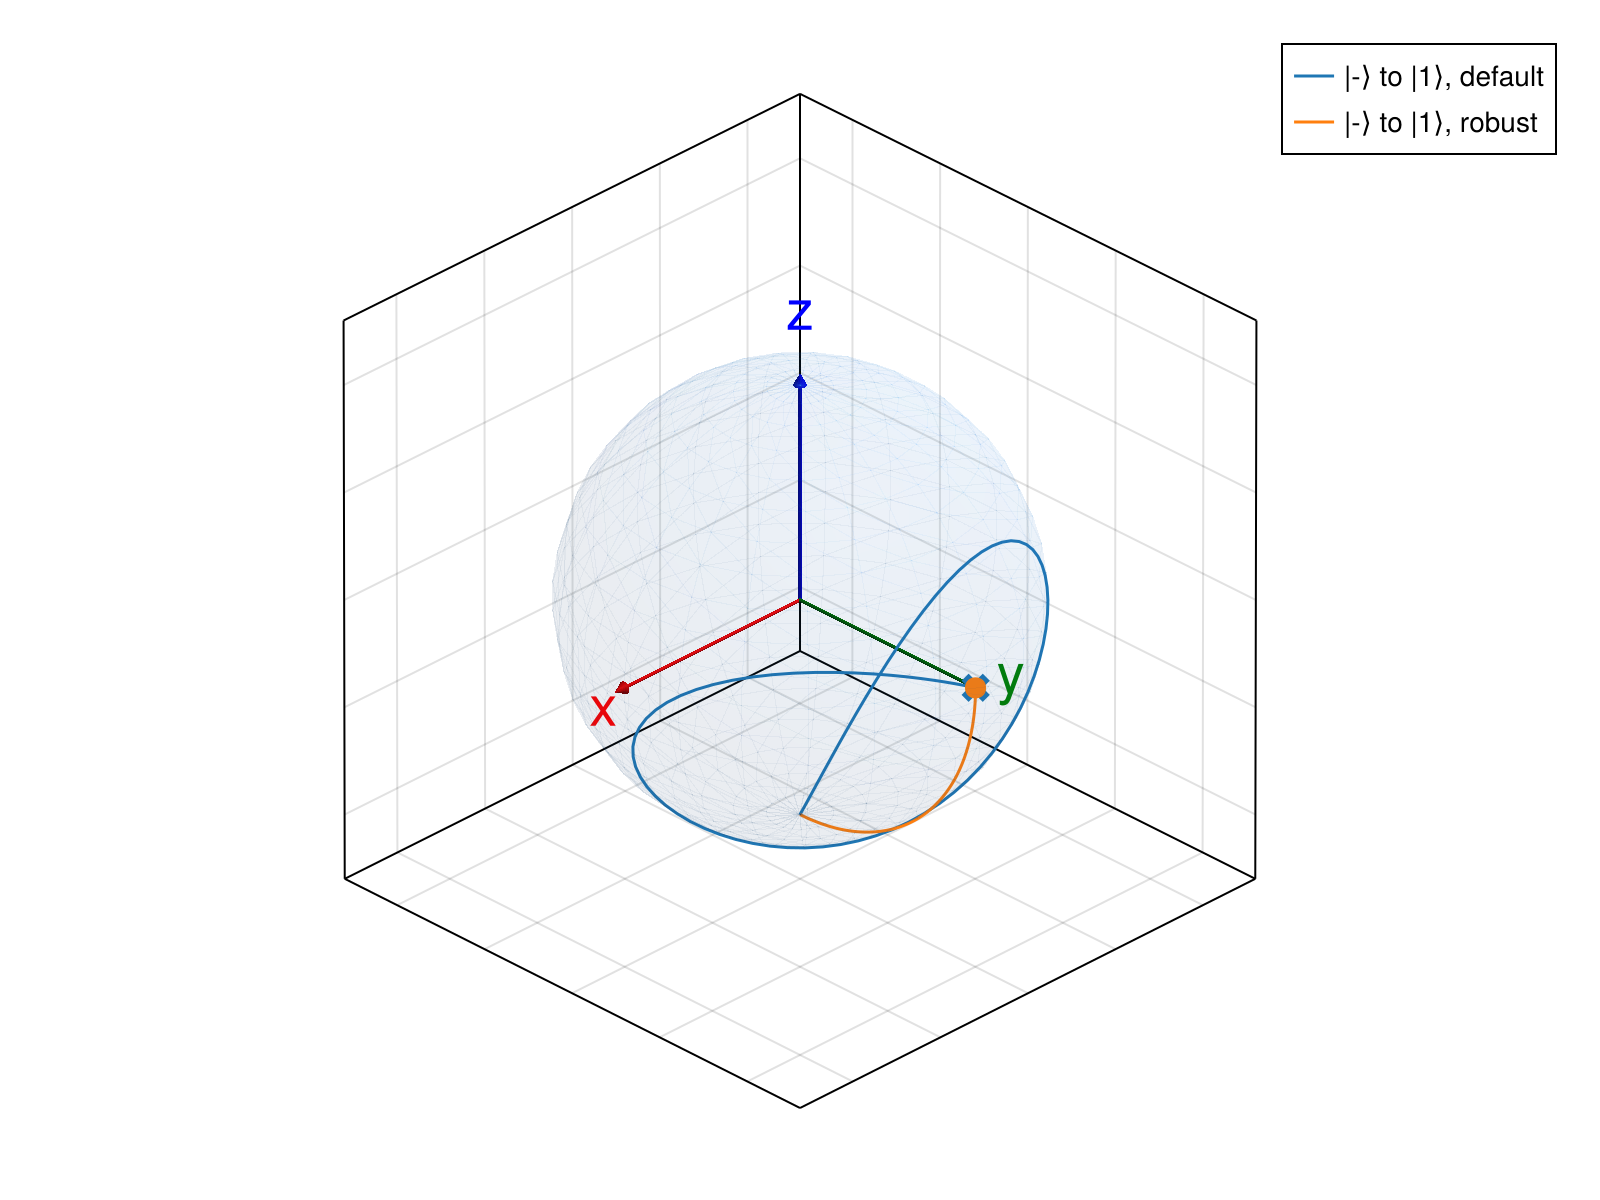

In [152]:
using CairoMakie          # Makie backend + plotting API
using GeometryBasics      # for Point3f/Vec3f

f  = CairoMakie.Figure(resolution = (800, 600))
ax = CairoMakie.Axis3(f[1, 1];
    aspect = :equal
)

palette = to_colormap(:tab10)
styles  = (:solid, :dash, :dot, :dashdot)

# --- axis arrows -------------------------------------------------------------
origins = [Point3f(0,0,0), Point3f(0,0,0), Point3f(0,0,0)]
dirs    = [Vec3f(1.0,0,0), Vec3f(0,1.0,0), Vec3f(0,0,1.0)]  # arrows unchanged

CairoMakie.arrows!(ax, origins, dirs;
    color = [:red, :green, :blue],
    arrowsize = 0.05,
    linewidth = 0.01
)

# Labels placed further than tip, font bigger
CairoMakie.text!(ax, "x", position = Point3f(1.2, 0, 0), align = (:left, :center),  color = :red,   fontsize = 28)
CairoMakie.text!(ax, "y", position = Point3f(0, 1.2, 0), align = (:center, :bottom), color = :green, fontsize = 28)
CairoMakie.text!(ax, "z", position = Point3f(0, 0, 1.2), align = (:center, :bottom), color = :blue,  fontsize = 28)

# --- trajectory --------------------------------------------------------------
CairoMakie.lines!(ax, real.(expect_val_x), real.(expect_val_y), real.(expect_val_z);
    color     = palette[1],
    linestyle = styles[1],
    label     = "|-⟩ to |1⟩, default",
    linewidth = 1.5
)

CairoMakie.lines!(ax, real.(expect_val_x_1), real.(expect_val_y_1), real.(expect_val_z_1);
    color     = palette[2],
    linestyle = styles[1],
    label     = "|-⟩ to |1⟩, robust",
    linewidth = 1.5
)

CairoMakie.scatter!(ax, [real(expect_val_x[end])], [real(expect_val_y[end])], [real(expect_val_z[end])];
    color = palette[1], markersize = 20, marker = :xcross)

CairoMakie.scatter!(ax, [real(expect_val_x_1[end])], [real(expect_val_y_1[end])], [real(expect_val_z_1[end])];
    color = palette[2], markersize = 15, marker = :circle)

# --- translucent unit sphere -------------------------------------------------
CairoMakie.mesh!(ax, Sphere(Point3f(0,0,0), 1f0);
    color = (0.2, 0.6, 1.0, 0.05),
    transparency = true,
    shading = true
)

# --- cosmetics ---------------------------------------------------------------
CairoMakie.xlims!(ax, -1.3, 1.3)
CairoMakie.ylims!(ax, -1.3, 1.3)
CairoMakie.zlims!(ax, -1.3, 1.3)

ax.azimuth[]   =  π/4
ax.elevation[] =  π/6

CairoMakie.axislegend(ax; position = :rt)
CairoMakie.hidexdecorations!(ax, grid = false)
CairoMakie.hideydecorations!(ax, grid = false)
CairoMakie.hidezdecorations!(ax, grid = false)

# CairoMakie.save("exact_1.png", f)
f

In [11]:
# using JLD2
# @load "artifacts/trajectories_YYYYMMDD_HHMMSS.jld2" default_trajs add_traj mult_traj fid_traces meta
